# 💻 Lab 3 - Generalized Linear Models (GLM) in PyMC

# ❗❗❗ Very important administrative detail

The lab changes its content once every **TWO WEEKS**.

*   week 1 & week 2 - lab1
*   week 3 & week 4 - lab2
*   **week 5 & week 6 - lab3**
* ...

# Structure of a GLM
Let's consider $Y_i$ be a response associated with covariates $X_i$ and parameters $\theta$. We call a **GLM** the following, where $Dist$ is a convenient distribution and $f$ maps covariates to the distribution parameters:

$Y_i|X_i, \theta \sim Dist(f(X_i; \theta))$

The formal definition is much more strict, $Dist$ being a member of the exponential family of distributions and the conditional mean $\mu_i = \mathbb{E}[Y_i|X_i]$ is linked to a linear predictor $X_i\beta$ via a link function $g$ (https://www.jstor.org/stable/2344614?origin=crossref).

 The goal of a bayesian approach to GLM is to find the posterior of $\theta$.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# Linear Regression

In classical ML we find the best parameters β, ϵ that parametrize a linear regression:

$Y=βX+ϵ$

If we view the problem probabilistically, $Y$ would be a random variable on which each data point is distributed:

$Y ∼ \mathcal{N}(\alpha + Xβ, σ^2)$

Our goal now is to find the posterior for β and ϵ using bayesian inference.

### The Intercept in Linear Regression

- The **intercept** ($\beta_0$) is the model’s **baseline prediction** when all input features are zero.

- General model:
  $$
  y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip} + \epsilon_i
  $$

- Interpretation:
  - $\beta_0$: value of $y$ when all $x_i = 0$
  - $\beta_j$: how much $y$ changes when feature $x_j$ increases by 1 (holding others constant)
  - $\epsilon_i$: random noise (unexplained variation)

- In matrix form, the intercept is included by adding a column of 1s in $X$:
  $$
  Y = X\beta + \epsilon
  $$

- Visually:
  - $\beta_0$ shifts the regression line **up or down** (controls vertical position)
  - $\beta_1, \beta_2, \dots$ control the **slope** (tilt of the line or plane)


## Example

Create a PyMC model and plot the posterior of the parameters for:

$Y ∼ \mathcal{N}(\alpha + Xβ, σ^2)$

The data generation process is defined below:

In [3]:
# data generation provided from: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html

size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame({"x": x, "y": y})

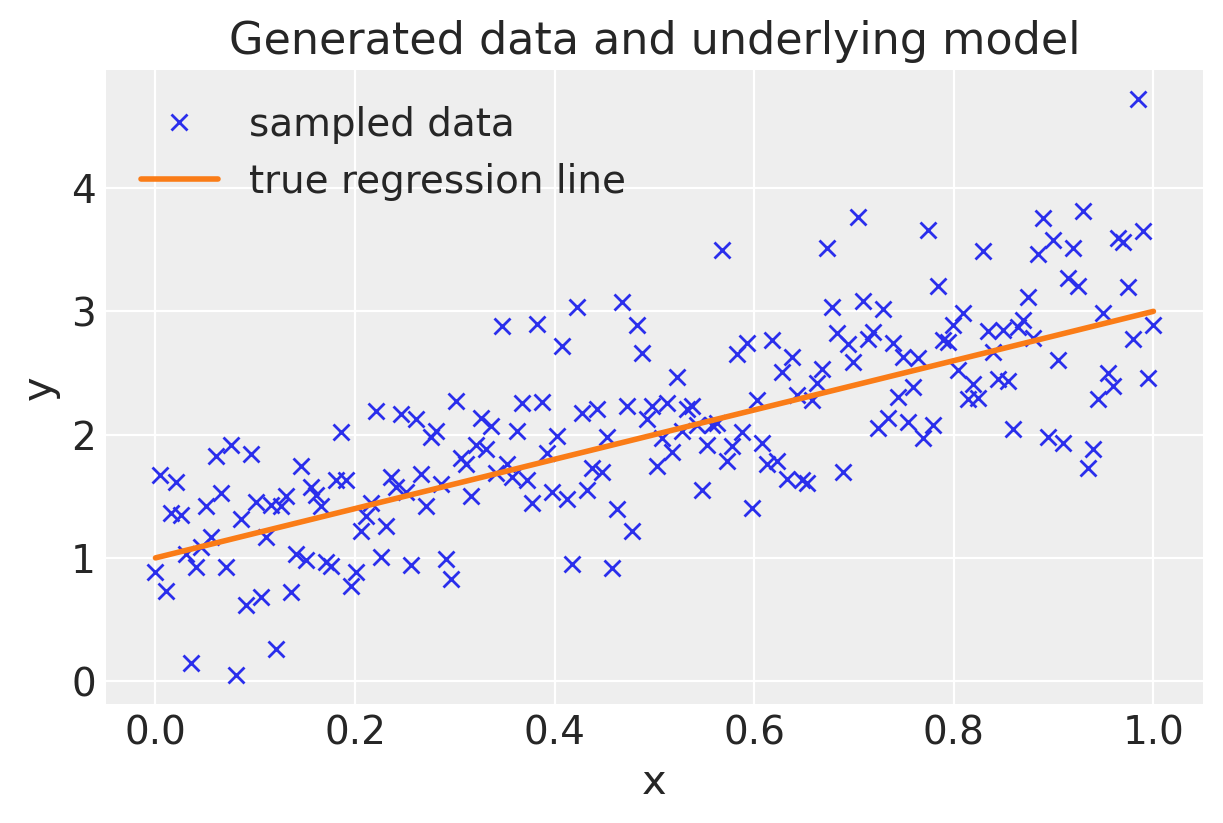

In [4]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [5]:
with pm.Model() as glm_0:
    sigma = pm.HalfNormal("sigma", sigma=10)
    intercept = pm.Normal("intercept", 0, sigma=10)
    slope = pm.Normal("slope", 0, sigma=10)

    obs = pm.Normal("obs", mu=intercept+slope*x, sigma=sigma, observed=y)
    step = pm.NUTS()
    trace_0 = pm.sample(3000, tune=2000, step=step, chains=4, progressbar=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]


c:\Users\Antonia\.conda\envs\python_env\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 27 seconds.


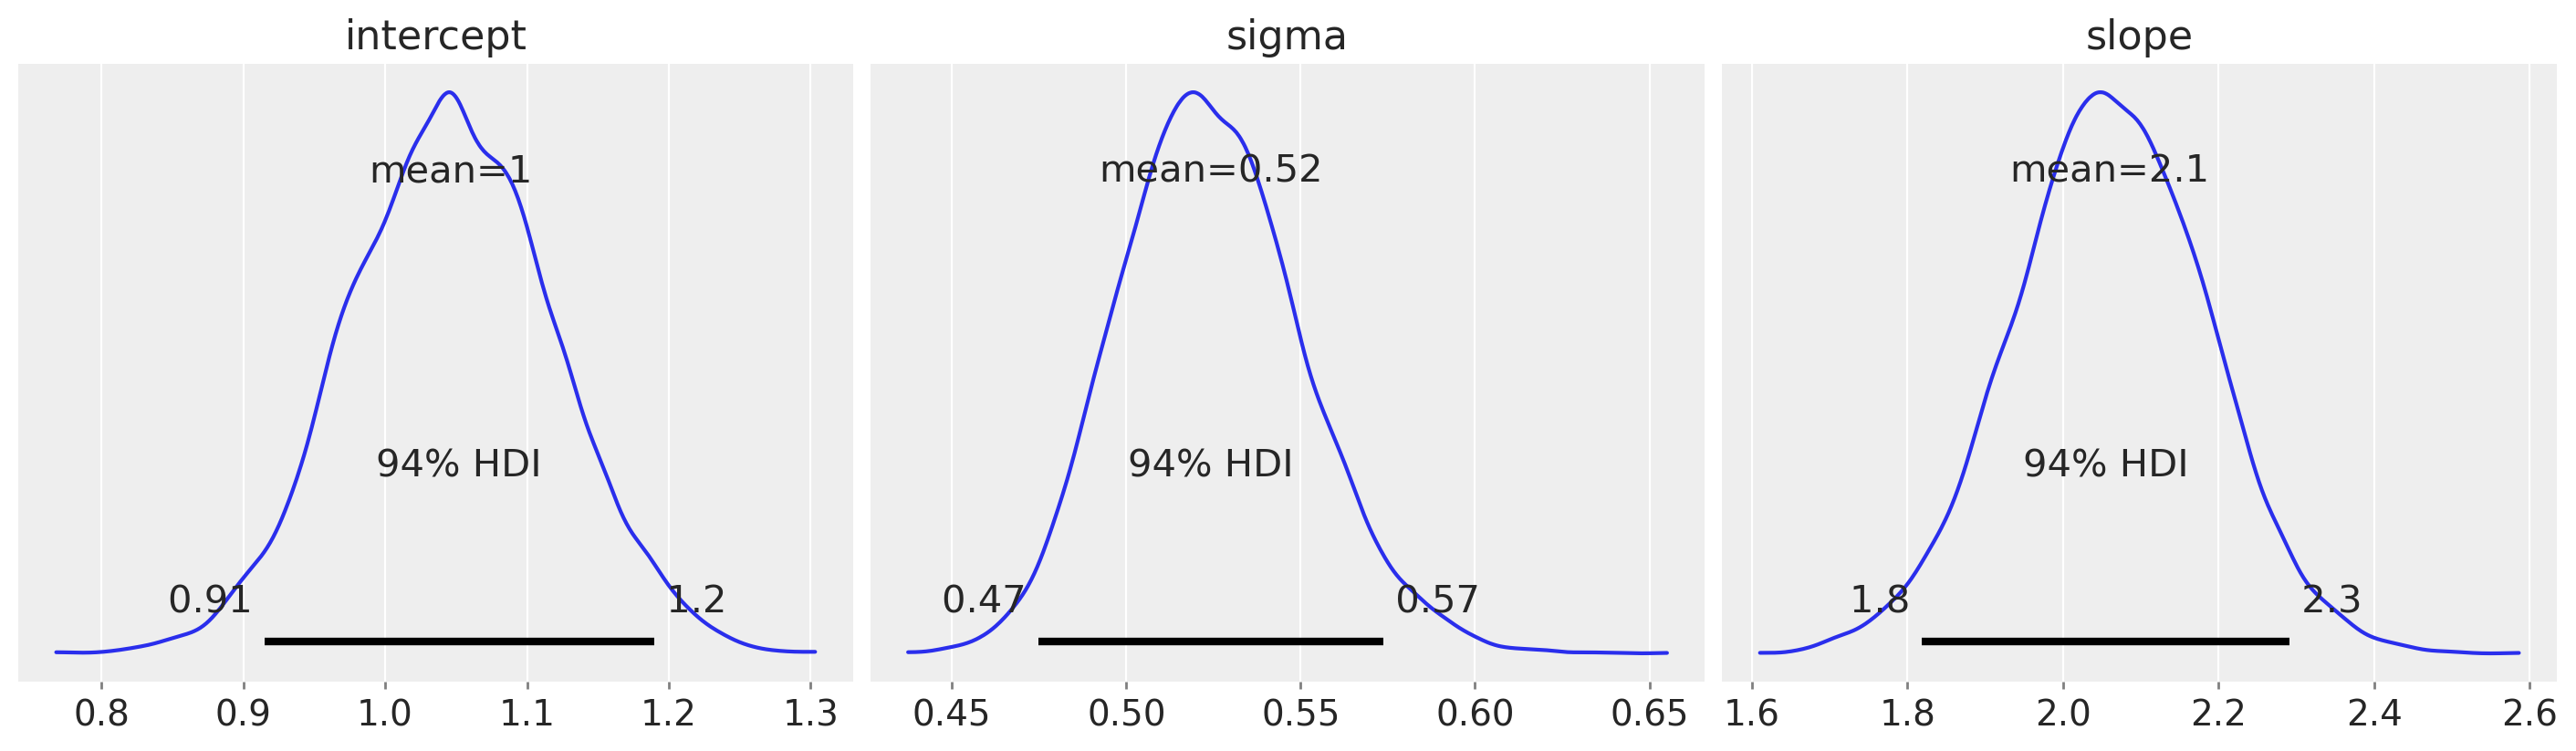

In [6]:
az.plot_posterior(trace_0, var_names=['intercept', 'sigma', 'slope'], figsize=(14, 4))
plt.show()
plt.close()

**The Highest Density Interval (HDI)** is a way to summarize a posterior distribution.

It’s the narrowest interval that contains a given percentage of the probability mass (commonly 95%).

Every point inside the interval has higher posterior density than points outside.

In other words: the HDI tells you where the bulk of plausible parameter values lie, according to the posterior.

C:\Users\Antonia\AppData\Local\Temp\ipykernel_24236\726957368.py:12: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(y_pred_flat, hdi_prob=0.94)


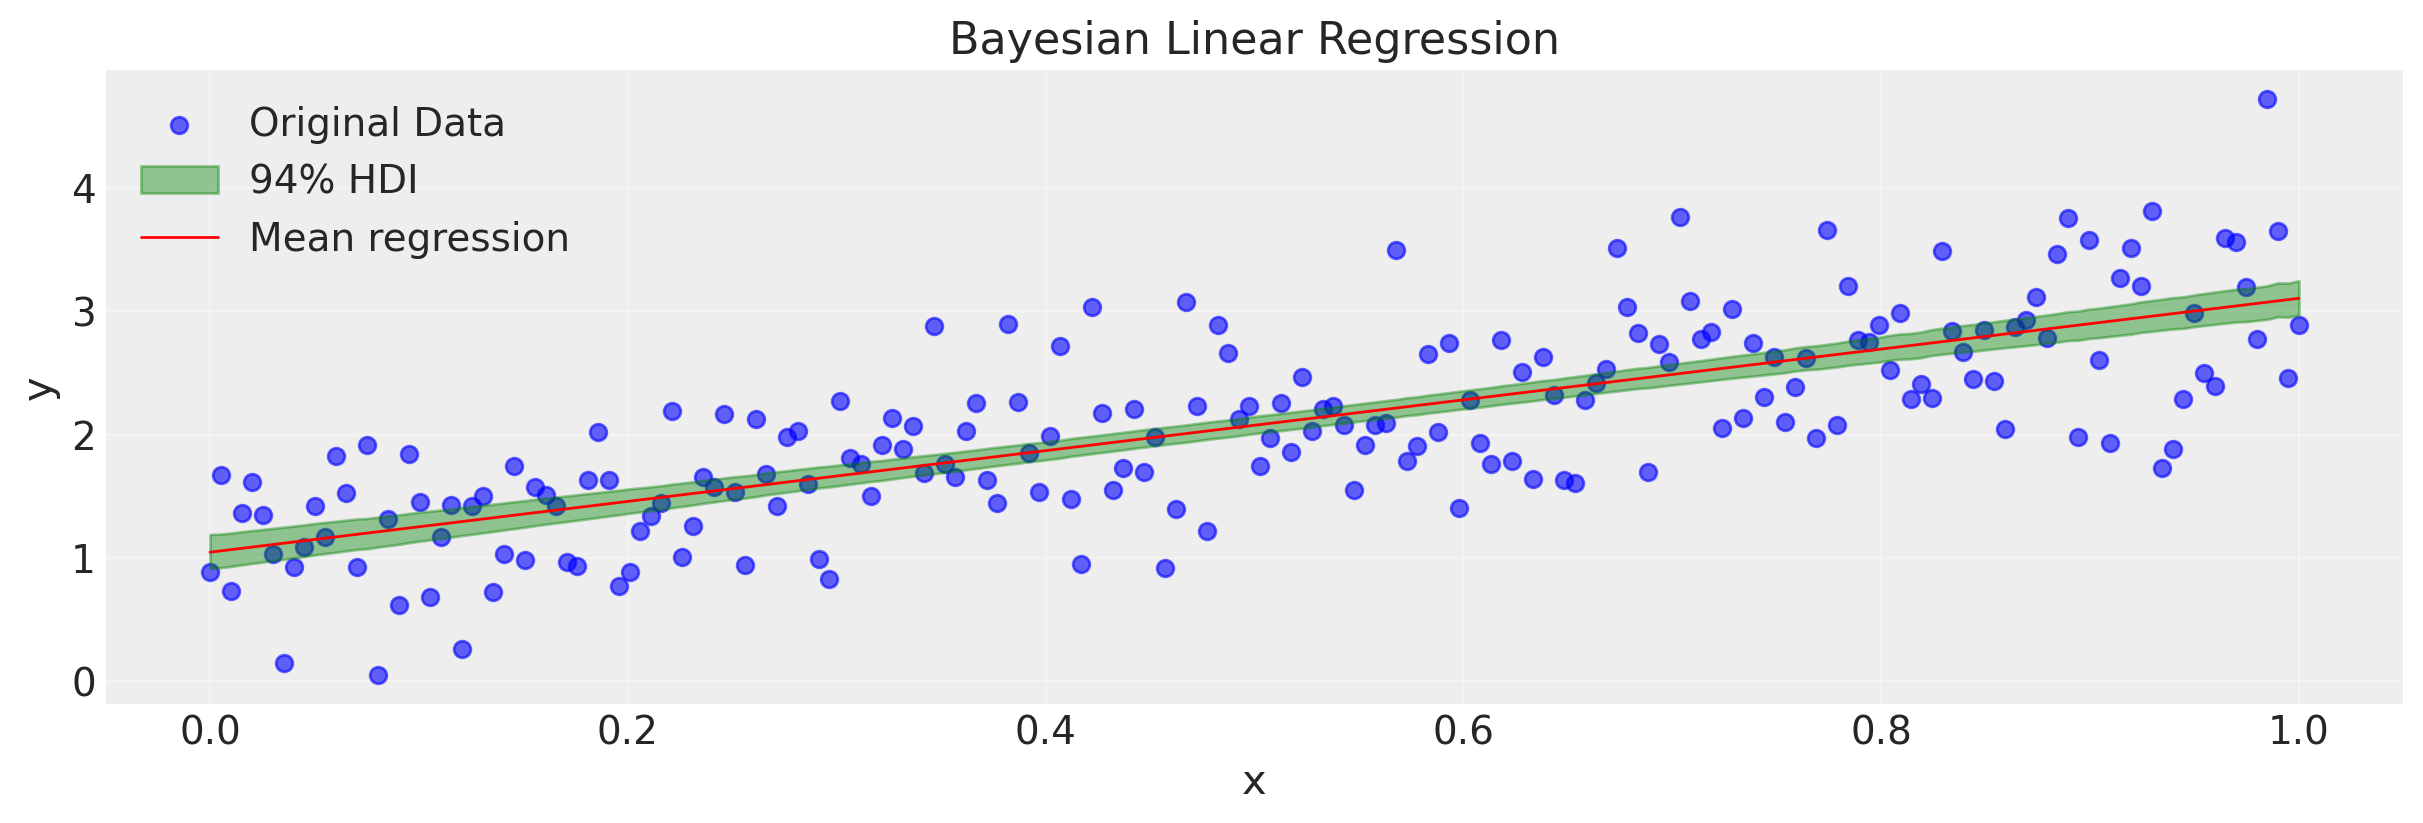

In [7]:
posterior = trace_0.posterior

y_pred = (
    posterior["intercept"].values[..., None] +
    posterior["slope"].values[..., None] * x
)

y_pred_flat = y_pred.reshape(-1, size)

y_mean = y_pred_flat.mean(axis=0)

hdi = az.hdi(y_pred_flat, hdi_prob=0.94)
hdi_lower, hdi_upper = hdi[:, 0], hdi[:, 1]

plt.figure(figsize=(12, 4))
plt.scatter(x, y, color="blue", alpha=0.6, label="Original Data")

plt.fill_between(x, hdi_lower, hdi_upper, color="green", alpha=0.4, label="94% HDI")

plt.plot(x, y_mean, color="red", lw=1, label="Mean regression")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Bayesian Linear Regression")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Exercises

## Exercise 1

Consider the following formulation for a GLM:

$Y_i|X_i, \theta \sim Dist(f(X_i; \theta))$

We are provided with a dataset about students in college with two columns $x$ and $y$ and we know that $x$ represents the number of hours studied by students. Find a valid distribution $Dist$ for the following cases:

(a) $Y$ is pass or fail after the exam.

(b) $Y$ is the final grade they achieve in the course.

(c) $Y$ is how many correct answers they provide out of 20 during the multiple choice exam.

(d) $Y$ is the time they spend for an exercise during the multiple choice exam.

(e) $Y$ is the amount of practice exercises they did before the exam date.

a) Bernoulli
b) Normal
c) Binomial
d) Exponential
e) Poisson

## Exercise 2

You are given the results of monitoring stress and skincare for patients suffering from a condition which manifests rashes on their skin. We **assume** (probably incorrectly) that:

* the rashes appear at a constant rate in a week
* the more stressed a person is, the more rashes they have
* the more prescribed skincare a person uses, the more they treat the rash
* the patients develop multiple rashes in a week and they are recorded in the dataset
* the records mention being stressed and **NOT** using the skincare, both cases increasing the possibility of rashes appearing on the skin.

In the dataset rashes.csv you find this data aggregated per week (the number of rashes as int and not using skincare/being stressed as booleans). Using PyMC, model a GLM with an **interaction** term: $\beta_0+\beta_1x_1+\beta_2x_2+\beta_3x_1x_2$

You can validate your work with posterior predictive check: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#posterior-predictive

💡 hint: after loading the dataframe in a variable df, run in a cell:

`df.groupby(["noskincare", "stress"])["nrashes"].agg(["mean", "var"])`

The mean and variance for each case have a pattern, is there a distribution known for modeling **COUNT DATA** which has that specific attribute?


### Interaction Term in Regression

An **interaction term** in a regression model represents the **combined effect of two variables** that is **more than just the sum of their individual effects**.

In your example:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2
$$

where:  
- $x_1$ = stressed (0 or 1)  
- $x_2$ = not using skincare (0 or 1)  

Then:  
- $\beta_1 x_1$ → effect of stress **alone**  
- $\beta_2 x_2$ → effect of not using skincare **alone**  
- $\beta_3 x_1 x_2$ → **extra effect** when both stress and no skincare are present simultaneously  

So if both stress and no skincare occur, the total effect on rashes is:

$$
\beta_1 + \beta_2 + \beta_3
$$

not just $\beta_1 + \beta_2$.


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, b2, b3]


c:\Users\Antonia\.conda\envs\python_env\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 1_145 draw iterations (8_000 + 4_580 draws total) took 91 seconds.
Sampling: [obs]


c:\Users\Antonia\.conda\envs\python_env\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<Axes: xlabel='obs'>

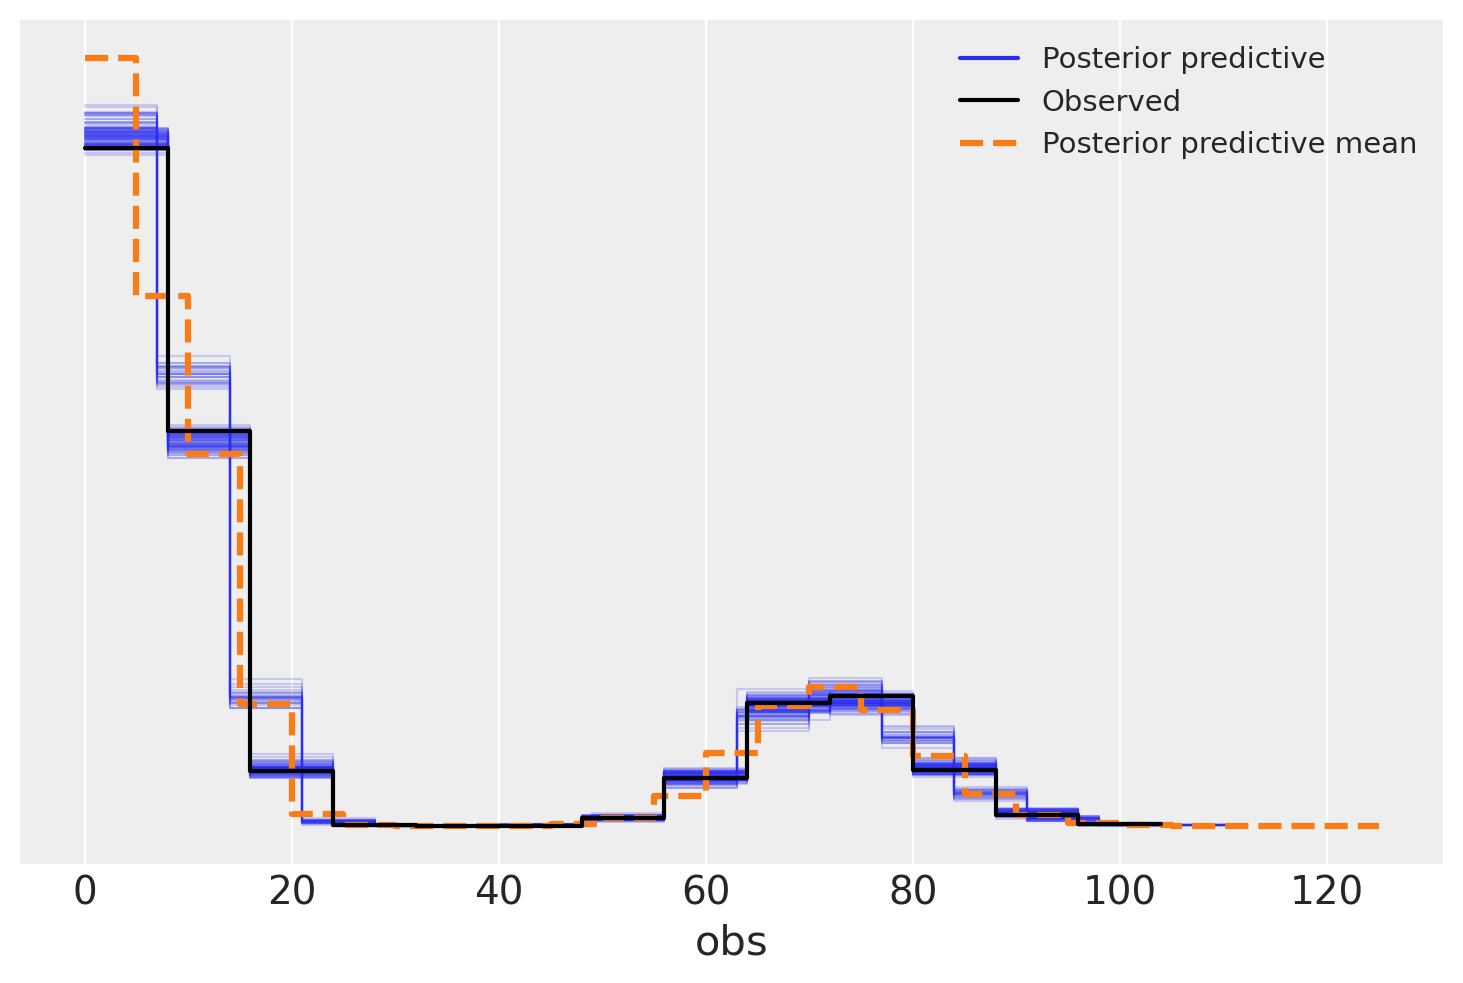

In [12]:
df=pd.read_csv("rashes.csv")
df.groupby(["noskincare", "stress"])["nrashes"].agg(["mean", "var"])
y=df["nrashes"]

x1=df["stress"].astype(int)
x2=df["noskincare"].astype(int)

with pm.Model() as model_rashes:
    b0=pm.Normal("b0",mu=0, sigma=10)
    b1=pm.Normal("b1",mu=0, sigma=10)
    b2=pm.Normal("b2",mu=0, sigma=10)
    b3=pm.Normal("b3",mu=0, sigma=10)

    mu=pm.math.exp(b0 + b1*x1 + b2*x2 + b3*x1*x2)

    obs = pm.Poisson("obs", mu=mu, observed=y)
    step=pm.NUTS()
    trace= pm.sample(3000, tune=2000, step=step, chains=4, progressbar=True)

with model_rashes:
    posterior_predictive = pm.sample_posterior_predictive(trace)

az.plot_ppc(posterior_predictive, num_pp_samples=100)

# Exercise 3

You are given a dataset of two measurements and their corresponding label in both train and test splits: (f_train.csv, f_test.csv). Using PyMC, develop a generative story for the label given the train measurements and use the posterior distributions to predict the test labels. Validate your model using the accuracy metric on the test set.

💡 hint: plot the train samples with their label and use your intuition for a decision boundary


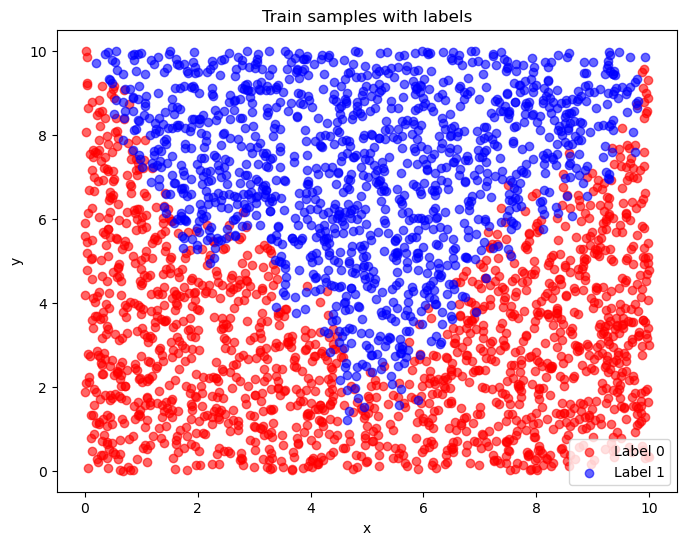

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv("f_train.csv")
df_test = pd.read_csv("f_test.csv")

plt.figure(figsize=(8, 6))
plt.scatter(df_train["x"][df_train["label"]==0], df_train["y"][df_train["label"]==0],
            color="red", alpha=0.6, label="Label 0")
plt.scatter(df_train["x"][df_train["label"]==1], df_train["y"][df_train["label"]==1],
            color="blue", alpha=0.6, label="Label 1")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Train samples with labels")
plt.legend()
plt.show()

In [3]:
import pymc as pm
import numpy as np

# Features and target
x1 = df_train["x"].values
x2 = df_train["y"].values
y = df_train["label"].values  # or continuous measurement

with pm.Model() as model_u_shape:
    
    # --- Priors ---
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # shifts the whole parabola up/down
    b1 = pm.Normal("b1", mu=0, sigma=10)               # linear effect of x1 (tilt)
    b2 = pm.Normal("b2", mu=0, sigma=10)               # linear effect of x2 (tilt)
    b3 = pm.Normal("b3", mu=0, sigma=10)               # quadratic effect of x1 (curvature)
    b4 = pm.Normal("b4", mu=0, sigma=10)               # quadratic effect of x2 (curvature)
    b5 = pm.Normal("b5", mu=0, sigma=10)               # interaction term x1*x2

    sigma = pm.HalfNormal("sigma", sigma=1)            # noise/scale

    # --- Mean of the generative model ---
    mu = (
        intercept
        + b1 * x1       # linear term
        + b2 * x2       # linear term
        + b3 * x1**2    # quadratic term for x1 → curvature
        + b4 * x2**2    # quadratic term for x2 → curvature
        + b5 * x1 * x2  # interaction term → tilt of U-shape in 2D
    )

    # --- Likelihood ---
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=y)

    # --- Sample posterior ---
    trace_u_shape = pm.sample(2000, tune=1000)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, b1, b2, b3, b4, b5, sigma]


c:\Users\Antonia\.conda\envs\python_env\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.


In [4]:
df_test = pd.read_csv("f_test.csv")
x1_test = df_test["x"].values
x2_test = df_test["y"].values
y_test = df_test["label"].values  # true labels

In [7]:
# Extract posterior samples as an xarray Dataset
posterior = trace_u_shape.posterior

# Convert to numpy arrays
intercept_samples = posterior["intercept"].values.flatten()[:, None]
b1_samples = posterior["b1"].values.flatten()[:, None]
b2_samples = posterior["b2"].values.flatten()[:, None]
b3_samples = posterior["b3"].values.flatten()[:, None]
b4_samples = posterior["b4"].values.flatten()[:, None]
b5_samples = posterior["b5"].values.flatten()[:, None]

# Compute mu for each posterior sample and each test point
mu_test_samples = (
    intercept_samples
    + b1_samples * x1_test
    + b2_samples * x2_test
    + b3_samples * x1_test**2
    + b4_samples * x2_test**2
    + b5_samples * x1_test * x2_test
)


In [8]:
# For binary labels
y_pred = (mu_test_samples.mean(axis=0) > 0.5).astype(int)

In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

Test set accuracy: 0.9083333333333333
